In [2]:
import torch
from torch import nn
from pandas import DataFrame
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
import numpy as np

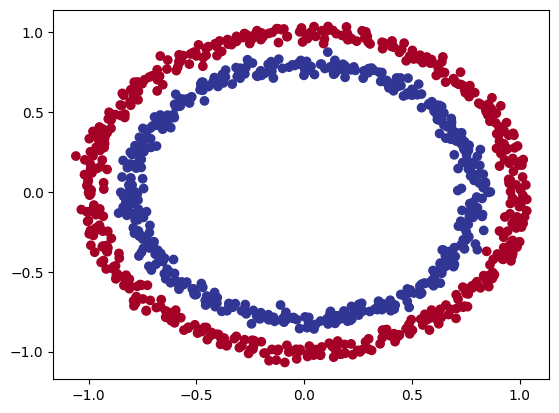

In [3]:
import torch
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Make and plot data
n_samples = 1000
X, y = make_circles(n_samples=n_samples, noise=0.03, random_state=42)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

# Split using NumPy arrays
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Convert to PyTorch tensors and move to CUDA
X_train = torch.from_numpy(X_train_np).float().to("cuda")
X_test = torch.from_numpy(X_test_np).float().to("cuda")
y_train = torch.from_numpy(y_train_np).float().to("cuda")
y_test = torch.from_numpy(y_test_np).float().to("cuda")

In [4]:
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

        # non linear activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        # where should we put our non linear activation function
        # x -> layer_1 -> relu -> layer_2 -> relu -> layer_3
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))


model_3 = CircleModelV2().to(device="cuda")

model_3.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[-0.2150,  0.0153],
                      [ 0.2262,  0.0645],
                      [ 0.5561,  0.4752],
                      [ 0.2574,  0.6652],
                      [ 0.0637, -0.2738],
                      [-0.4342, -0.3134],
                      [ 0.5512, -0.0792],
                      [ 0.6726,  0.0214],
                      [ 0.1776,  0.4260],
                      [ 0.4564, -0.1832]], device='cuda:0')),
             ('layer_1.bias',
              tensor([-0.0011, -0.6516,  0.4433, -0.3169,  0.2090,  0.0263,  0.1161,  0.0856,
                      -0.0990,  0.2701], device='cuda:0')),
             ('layer_2.weight',
              tensor([[-0.2176,  0.0164, -0.0052,  0.1067, -0.1679,  0.2857, -0.1483,  0.2757,
                       -0.2911,  0.0050],
                      [-0.1958, -0.1974, -0.0467,  0.0288,  0.0455, -0.1433,  0.2678, -0.0312,
                       -0.1151,  0.2091],
                      [ 0.0995, -0.080

In [5]:
loss_fn = nn.BCEWithLogitsLoss()

optimzer = torch.optim.SGD(params=model_3.parameters(), lr=0.1)



In [6]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [7]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [8]:
epochs = 2000

for epoch in range(epochs):
    model_3.train()
    y_logits = model_3(X_train).squeeze()
    
    y_preds = torch.round(torch.sigmoid(y_logits))
    
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_preds)
    
    optimzer.zero_grad()
    
    loss.backward()
    
    optimzer.step()
    
    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_loss = loss_fn(y_test, test_logits)
        test_logits_preds = torch.round(torch.sigmoid(test_logits))
        test_preds = accuracy_fn(y_true=y_test, y_pred=test_logits_preds)
        
        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | Train loss: {loss:.5f} | Test loss: {test_loss:.5f} | Train acc: {acc:.2f}% | Test acc: {test_preds:.2f}%")

Epoch: 0 | Train loss: 0.69537 | Test loss: 1.04002 | Train acc: 45.00% | Test acc: 47.00%
Epoch: 10 | Train loss: 0.69491 | Test loss: 1.03219 | Train acc: 47.25% | Test acc: 47.50%
Epoch: 20 | Train loss: 0.69439 | Test loss: 1.02661 | Train acc: 48.38% | Test acc: 47.50%
Epoch: 30 | Train loss: 0.69393 | Test loss: 1.02248 | Train acc: 49.50% | Test acc: 48.00%
Epoch: 40 | Train loss: 0.69367 | Test loss: 1.01947 | Train acc: 49.50% | Test acc: 48.50%
Epoch: 50 | Train loss: 0.69346 | Test loss: 1.01731 | Train acc: 49.50% | Test acc: 48.50%
Epoch: 60 | Train loss: 0.69327 | Test loss: 1.01579 | Train acc: 49.50% | Test acc: 48.50%
Epoch: 70 | Train loss: 0.69309 | Test loss: 1.01473 | Train acc: 50.25% | Test acc: 50.00%
Epoch: 80 | Train loss: 0.69292 | Test loss: 1.01395 | Train acc: 49.88% | Test acc: 50.50%
Epoch: 90 | Train loss: 0.69275 | Test loss: 1.01333 | Train acc: 50.00% | Test acc: 51.00%
Epoch: 100 | Train loss: 0.69259 | Test loss: 1.01288 | Train acc: 50.50% | Test 

In [9]:
# Make predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()

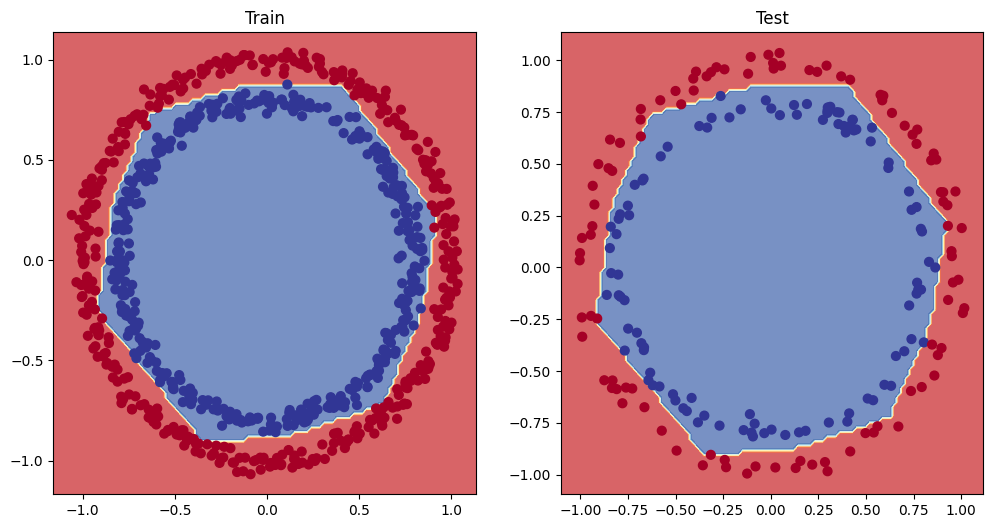

In [10]:
# Plot decision boundaries for training and test sets
from helper_functions import plot_decision_boundary


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)  # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)  # model_3 = has non-linearity



# replicating non linear activation functions 

In [11]:
# create a tensor 

A = torch.arange(-10, 10, 1, dtype=torch.float32)
A.dtype

torch.float32

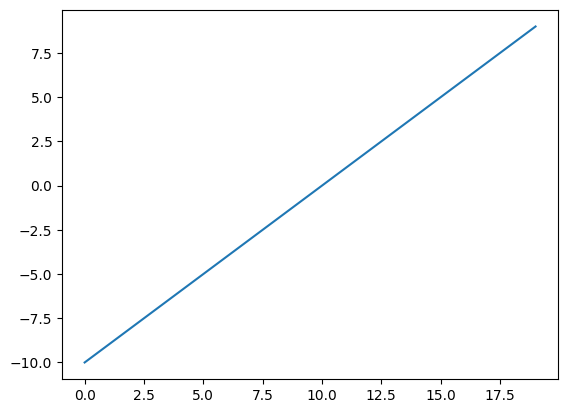

In [12]:
# visualizing the data 

plt.plot(A)

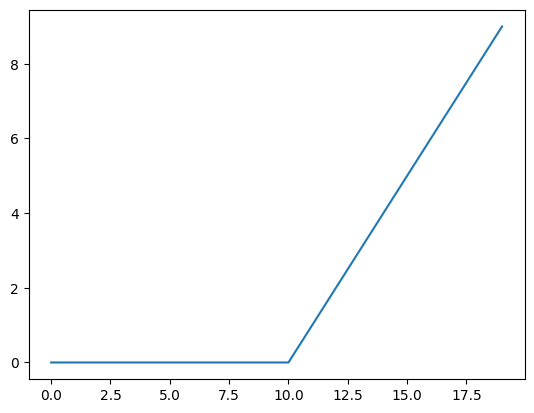

In [13]:
plt.plot(torch.relu(A))

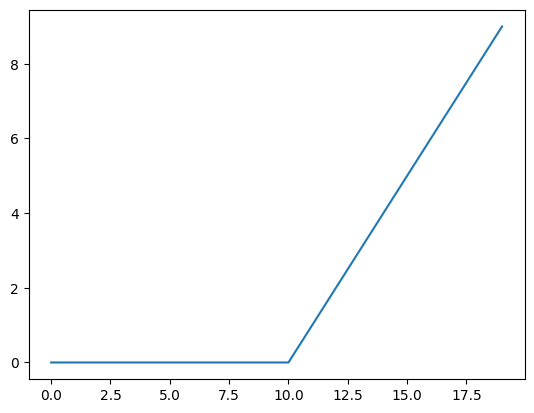

In [14]:
def relu(x: torch.Tensor):
    return torch.maximum(torch.tensor(0), x) # inputs must be tensors 


plt.plot(relu(A))

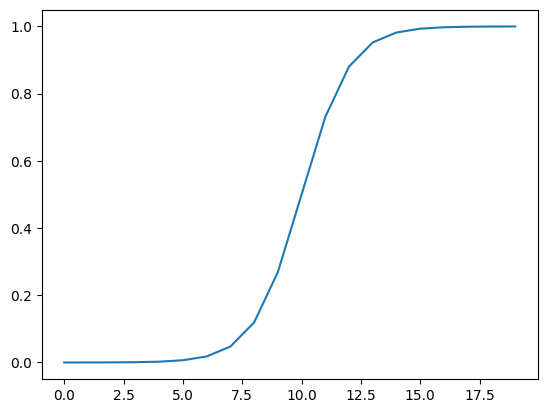

In [15]:
def sigmoid(x:torch.Tensor):
    return 1 / (1 + torch.exp(-x))
    
    
plt.plot(sigmoid(A))

# putting it all together with multi class classification problem

### creating a toy dataset

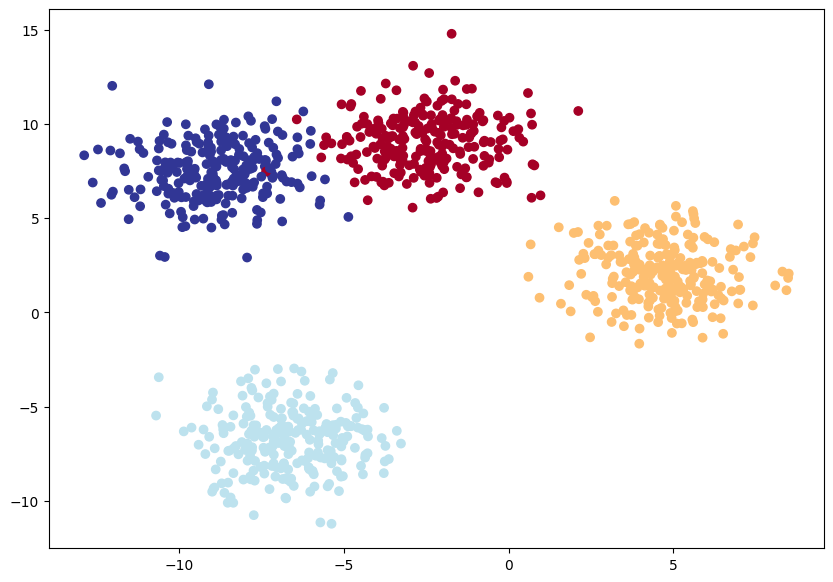

In [16]:
import torch 
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs 
from sklearn.model_selection import train_test_split
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# CREATE MULTI CLASS DATA 
X_blob, y_blob = make_blobs(n_samples=1000, n_features=NUM_FEATURES, centers=NUM_CLASSES, cluster_std=1.5, random_state=RANDOM_SEED)

# turn data into tensors 
X_blob = torch.from_numpy(X_blob).type(torch.float32)
y_blob = torch.from_numpy(y_blob).type(torch.float32)

# split into train and test 
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state =RANDOM_SEED)

#  plot the data 

plt.figure(figsize=(10,7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)


## bulding a multiclass classification model

In [17]:
# creating device agnostic cide

device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'